In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import pandas as pd
size = (256, 256)

import torch

torch.cuda.is_available()

c:\users\1\desktop\tpsh-segm\venv\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


True

In [7]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [8]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [9]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(12, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)

        return output_mask

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet()
model.to(device)
model.eval()

UNet(
  (e1): encoder(
    (conv): conv(
      (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder(
    (conv): conv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, 

768 1280


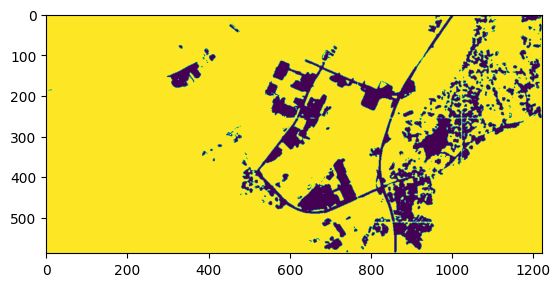

In [14]:
#h w d
import torchvision 
from torchvision.io import read_image 
from torchvision.utils import make_grid 
model.load_state_dict(torch.load('./checkpoint.pth'))
image = np.load("images_np/2022-09-21.npy")
# "images_np/2022-09-21.npy"
a = image.shape[1]
b = image.shape[2]
a1 = a
b1 = b
if a % 256 != 0:
    a = (a//256+1)*256
if b % 256 != 0:
    b = (b//256+1)*256
print(a, b)
image = np.transpose(image, (1, 2, 0))
new = np.zeros((a, b, 12))
new[:image.shape[0], :image.shape[1],:] = image
data = []
for i in range(a//256):
    for j in range(b//256):
        data.append(new[i*256:(i+1)*256, j*256:(j+1)*256, :])
im = image
new_dat = []
for i in range(len(data)):
    image = np.transpose(data[i], (2, 0, 1))
    logits_mask = model(torch.tensor(image).to(device, dtype=torch.float32).unsqueeze(0))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.7) *1.0
    data[i]=np.transpose(pred_mask.detach().cpu().squeeze(0), (1, 2, 0))
    
# k = np.concatenate((*data), axis=1)

fn = 1
for i in range(a//256):
    if i==0:
        k = data[i*(b//256)]
        for j in range(1, b//256):
            k = np.concatenate((k, data[i*(b//256)+j]), axis=1)
        f = k
    else:
        k = data[i*(b//256)]
        for j in range(1, b//256):
            k = np.concatenate((k, data[i*(b//256)+j]), axis=1)
        f = np.concatenate((f, k), axis=0)
f = f[:a1, :b1]
plt.imshow(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


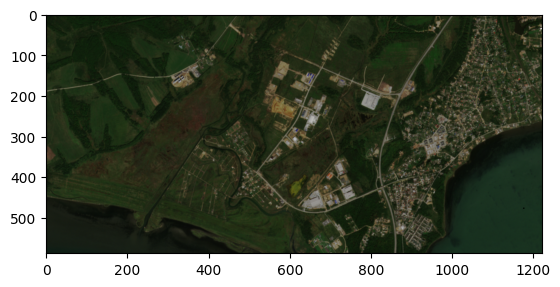

In [17]:
plt.imshow(im[:,:,:3])